# Vehicle Detection and Tracking

## Importing some libraries

In [1]:
import numpy as np
import cv2
import glob

import time
import sys

import PIL
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from tqdm import tqdm

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from collections import deque
from skimage.transform import resize
from scipy.ndimage.measurements import label

## Training the classifier

### Reading the training data


Reading vehicle training data:


100%|████████████████████████████████████| 8792/8792 [00:03<00:00, 2521.51it/s]



Imported vehicle training data: 8792 images


Reading non-vehicle training data:


100%|████████████████████████████████████| 8968/8968 [00:03<00:00, 2606.52it/s]


Imported non-vehicle training data: 8968 images



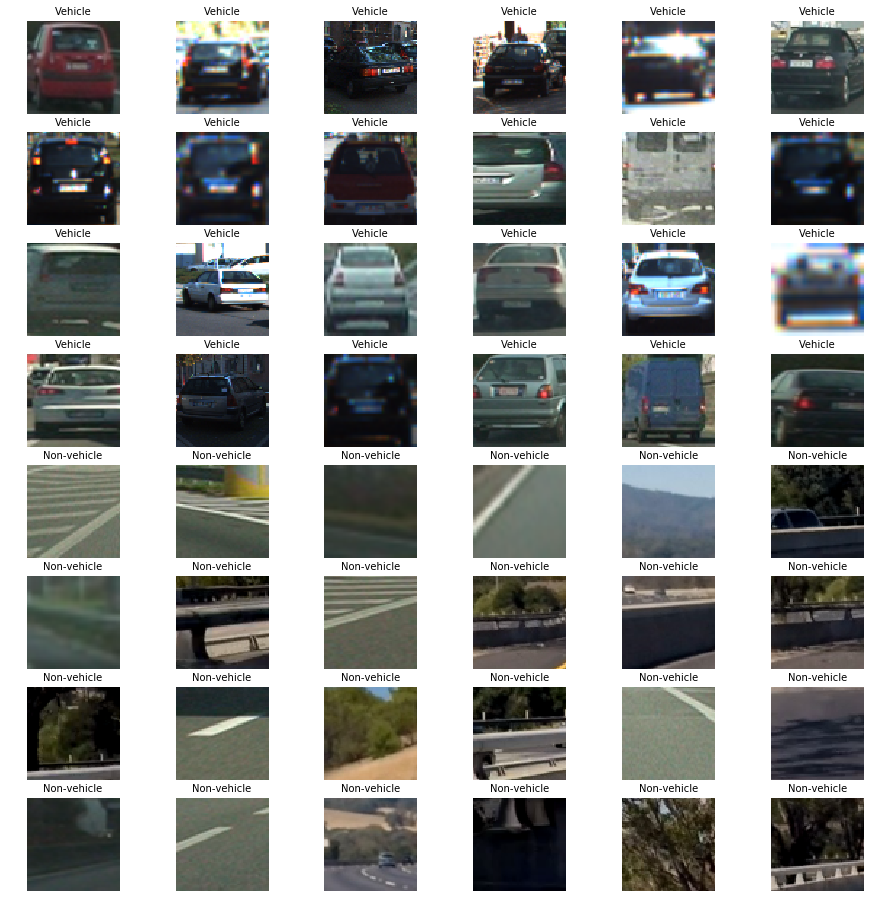

In [2]:

# Prepare to plot some traing samples

fig, axs = plt.subplots(8,6, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Read vehicle training data
vehicles = []
vehicles_images = glob.glob('training_data/vehicles/*/*.png')

print('\nReading vehicle training data:')

progress_bar = tqdm(total=len(vehicles_images))

for img in vehicles_images:
    vehicles.append(mpimg.imread(img))
    progress_bar.update(1)

vehicles = np.asarray(vehicles)
progress_bar.close()

print('\nImported vehicle training data: {} images\n'.format(vehicles.shape[0]))

for i in np.arange(24):
    img = cv2.imread(vehicles_images[np.random.randint(0,len(vehicles_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Vehicle', fontsize=10)
    axs[i].imshow(img)
    
# Read non-vehicle training data
      
non_vehicles = []
non_vehicles_images = glob.glob('training_data/non-vehicles/*/*.png')      

print('\nReading non-vehicle training data:')

progress_bar = tqdm(total=len(non_vehicles_images))

for img in non_vehicles_images:
    non_vehicles.append(mpimg.imread(img))
    progress_bar.update(1)

non_vehicles = np.asarray(non_vehicles)
progress_bar.close()


print('Imported non-vehicle training data: {} images\n'.format(non_vehicles.shape[0]))

for i in np.arange(24,48):
    img = cv2.imread(non_vehicles_images[np.random.randint(0,len(non_vehicles_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Non-vehicle', fontsize=10)
    axs[i].imshow(img)

### Feature extraction functions

In [3]:
def get_hog_features(img, orient=10, pix_per_cell=8, cell_per_block=2, vis=False):    

    hog_features = []
    
    if vis == False:
        for channel in range(img.shape[2]): 
            feature = hog(img[:, :, channel], 
                              orientations=orient, 
                              pixels_per_cell=(pix_per_cell,pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), 
                              transform_sqrt=True, 
                              visualize=vis,
                              feature_vector=False)

            hog_features.append(feature)        
        return np.asarray(hog_features)    
    else:
        for channel in range(img.shape[2]): 
            feature, hog_image= hog(img[:, :, channel], 
                              orientations=orient, 
                              pixels_per_cell=(pix_per_cell,pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), 
                              transform_sqrt=True, 
                              visualize=vis,
                              feature_vector=False)
            
            hog_features.append(feature)        
        return np.asarray(hog_features), hog_image    

# Computes binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(img, 
                      hog_features = [],
                      x=0, 
                      y=0, 
                      s=64,                            
                      spatial_size=(32, 32),
                      orient=10, 
                      pix_per_cell=8, 
                      cell_per_block=2):
    features = []
    # Add spactial features
    spatial = bin_spatial(img[y:y + s, x:x + s, :], size=spatial_size)
    features.append(spatial)
    # Add HOG features 
    
    _x = max((x // pix_per_cell) - 1, 0)
    _y = max((y // pix_per_cell) - 1, 0)
    _s = (s // pix_per_cell) - 1

    if (_x + _s) > hog_features.shape[2]:
        _x = hog_features.shape[2] - _s

    if (_y + _s) > hog_features.shape[1]:
        _y = hog_features.shape[1] - _s

    hog = np.ravel(hog_features[:, _y:_y + _s, _x:_x + _s, :, :, :])

    features.append(hog)
    # Add Histogram features
    hist = color_hist(img[y:y + s, x:x + s, :])
    features.append(hist)
    # Concatenate the features and return
    return np.concatenate(features)

def extract_training_features(images):


    training_features = []

    progress_bar = tqdm(total=len(images))
    for img in images:

        img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        hog_features = get_hog_features(img)
        features = extract_features(img, hog_features)
        training_features.append(features)    
        progress_bar.update(1)      
    progress_bar.close()

    return training_features


### Extracting vehicle and non-vehicle features

In [4]:
print('\nExtracting vehicle features:')

vehicle_features = extract_training_features(vehicles)

print('\nExtracting non-vehicle features:')

non_vehicle_features = extract_training_features(non_vehicles)


Extracting vehicle features:


  0%|                                                 | 0/8792 [00:00<?, ?it/s]C:\Users\uidp7920\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
100%|█████████████████████████████████████| 8792/8792 [00:34<00:00, 254.04it/s]



Extracting non-vehicle features:


100%|█████████████████████████████████████| 8968/8968 [00:33<00:00, 267.97it/s]


### Example of extracted HOG features 

C:\Users\uidp7920\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


Text(0.5,1,'Extracted HOG')

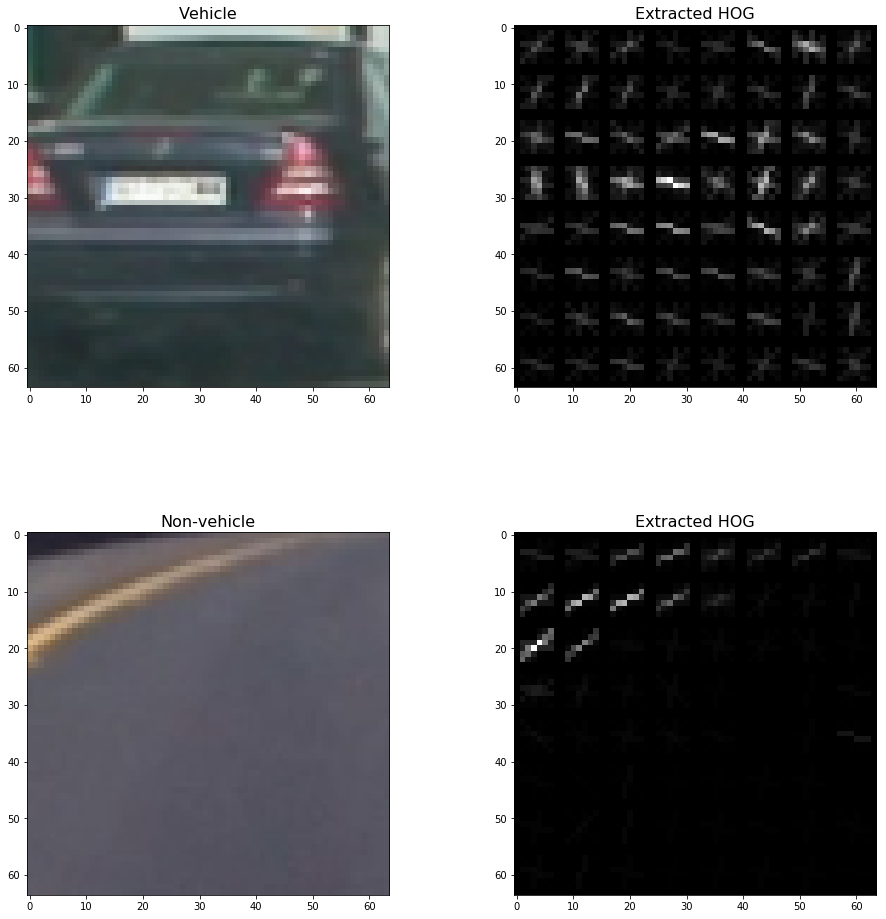

In [5]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,16))
f.subplots_adjust(hspace = .4, wspace=.2)

vehicle_img = cv2.imread(vehicles_images[1000])
vehicle_img = cv2.cvtColor(vehicle_img,cv2.COLOR_BGR2RGB)
                           
ax1.imshow(vehicle_img)
ax1.set_title('Vehicle', fontsize=16)

vehicle_img = cv2.cvtColor(vehicle_img,cv2.COLOR_RGB2YCrCb)
_, vehicle_dst = get_hog_features(vehicle_img, vis = True)

ax2.imshow(vehicle_dst, cmap='gray')
ax2.set_title('Extracted HOG', fontsize=16)

non_vehicle_img = cv2.imread(non_vehicles_images[100])
non_vehicle_img = cv2.cvtColor(non_vehicle_img,cv2.COLOR_BGR2RGB)
                           
ax3.imshow(non_vehicle_img)
ax3.set_title('Non-vehicle', fontsize=16)

non_vehicle_img = cv2.cvtColor(non_vehicle_img,cv2.COLOR_RGB2YCrCb)
_, non_vehicle_dst = get_hog_features(non_vehicle_img, vis = True)

ax4.imshow(non_vehicle_dst, cmap='gray')
ax4.set_title('Extracted HOG', fontsize=16)

### Scalling and splitting features

In [6]:
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)

# Scale
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=43)


### Train the linear SVC classifier

In [7]:
# Use a linear SVC 

svc = LinearSVC()

svc.fit(X_train, y_train)

accuracy = round(svc.score(X_test, y_test), 5)
print('Linear SVC classifier accuracy: {}'.format(accuracy))

Linear SVC classifier accuracy: 0.98874


## Detect Vehicles using the classifier

In [8]:
class Pipeline(object):
    

    def __init__(self, scaler, classifier, f_img):
        self.scaler = scaler
        self.classifier = classifier
        self.img_shape = f_img.shape
        self.history = deque(maxlen=20)
    
    def _pass_sliding_window(self, img):
        scales = np.array([0.3, 0.5, 0.65, 0.8])
        y_top  = np.array([0.6, 0.57, 0.56, 0.55])

        img_detections = np.empty([0, 4], dtype=np.int64)
            

        img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        
        for scale, y in zip(scales, y_top):                    
            
            
            (height, width, depth) = img.shape
            resized = resize((img / 255.0).astype(np.float64),
                            (int(height * scale), int(width * scale), depth),
                            preserve_range=True).astype(np.float32)

            hog_features = get_hog_features(resized)

            (height, width, depth) = resized.shape
            detections = np.empty([0, 4], dtype=np.int)
            
            k = 64
            y = int(height * y)
            s = k // 3
            x_range = np.linspace(0, width - k, (width + s) // s)


            
            for x in x_range.astype(np.int):
                
                features = extract_features(resized, hog_features, x, y, k)
                
                features = self.scaler.transform(np.array(features).reshape(1, -1))

                if self.classifier.predict(features)[0] == 1:
                    detections = np.append(detections, [[x, y, x + k, y + k]], axis=0)

            scale_detections = (detections / scale).astype(np.int)
            
            img_detections = np.append(img_detections, scale_detections, axis=0)

        detections, self.heatmap = self._merge_detections(img_detections, img.shape, threshold=1)

        self.history.append(detections)

    def _merge_detections(self, detections, img_shape, threshold):
        
        
        heatmap = np.zeros((img_shape[0], img_shape[1])).astype(np.float)
        for d in detections:
            heatmap[d[1]:d[3], d[0]:d[2]] += 1

        # Apply threshold to remove false positives
        heatmap[heatmap < threshold] = 0
        heatmap = np.clip(heatmap, 0, 255)

        labels = label(heatmap)
        vehicles = np.empty([0, 4], dtype=np.int64)

        # for each detected vehicle:
        for vehicle in range(1, labels[1] + 1):
            nonzero = (labels[0] == vehicle).nonzero()
            nonzero_min_max = [[np.min(nonzero[1]), np.min(nonzero[0]),
                                np.max(nonzero[1]), np.max(nonzero[0])]]
            vehicles = np.append(vehicles, nonzero_min_max, axis=0)

        return (vehicles, heatmap)

    def run(self, img):
        self._pass_sliding_window(img)
        
        detections, _ = self._merge_detections(
            np.concatenate(np.array(self.history)),
            self.img_shape,
            threshold=min(len(self.history), 10)
        )

        for d in detections:
            cv2.rectangle(img, (d[0], d[1]), (d[2], d[3]), (0, 0, 255), 2)

        return img

## Use the classifier on a set of test images

C:\Users\uidp7920\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\uidp7920\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\uidp7920\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


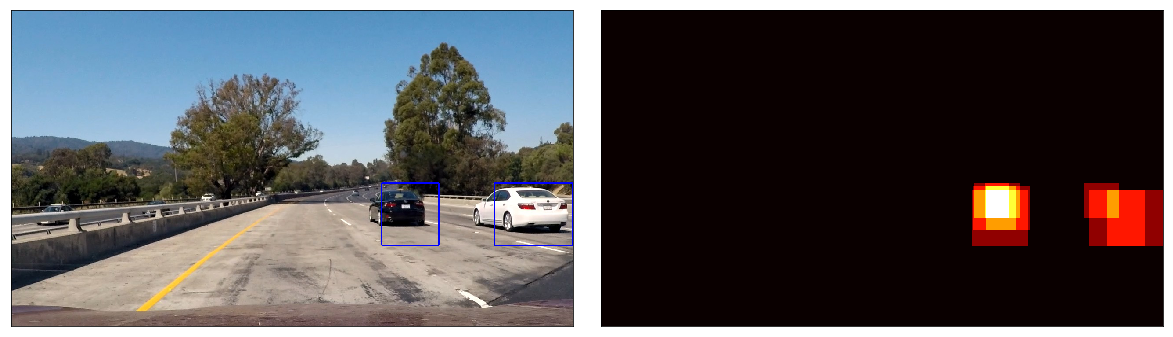

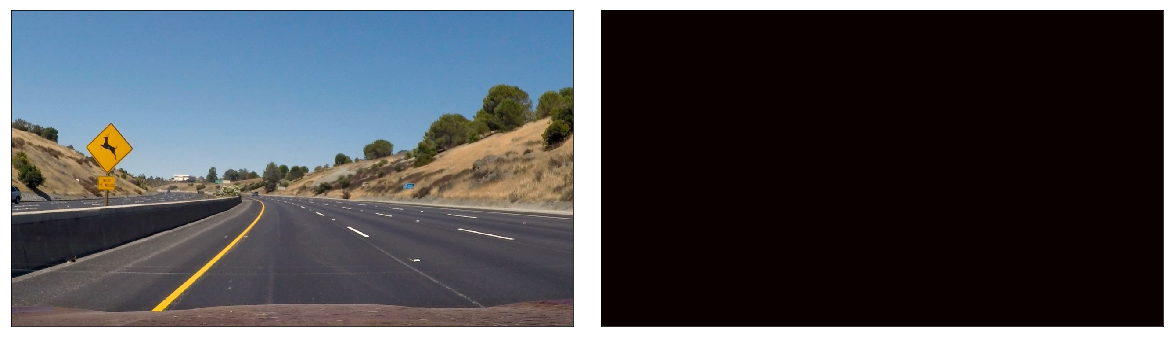

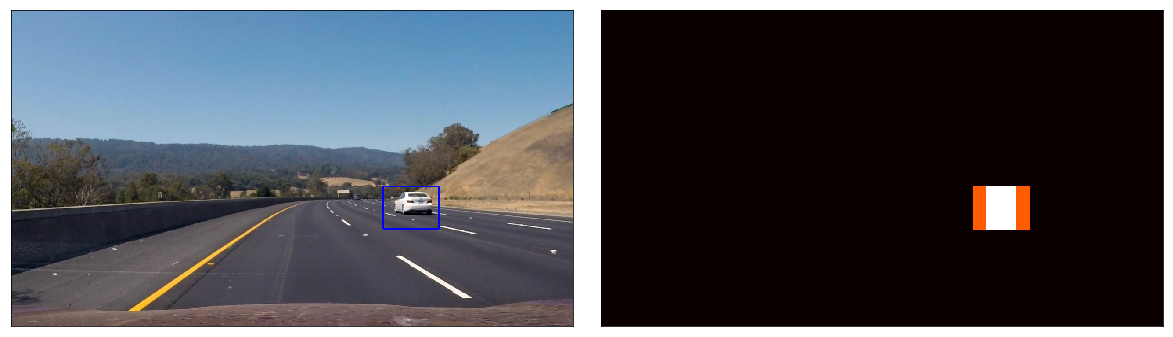

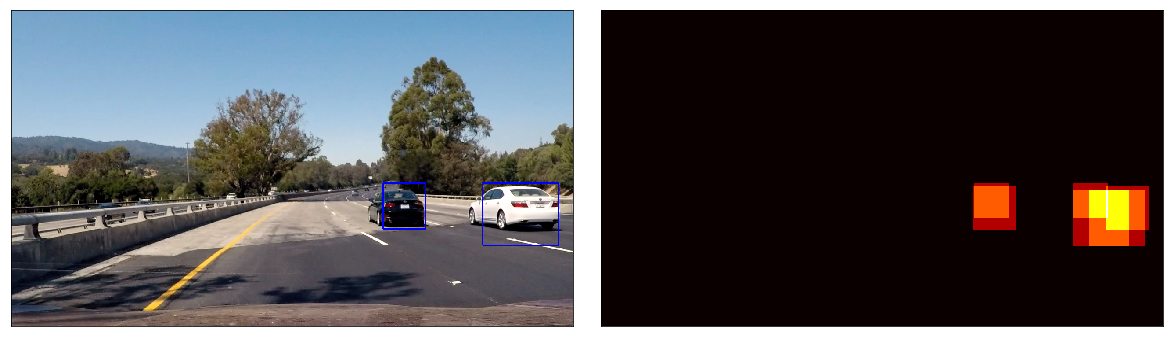

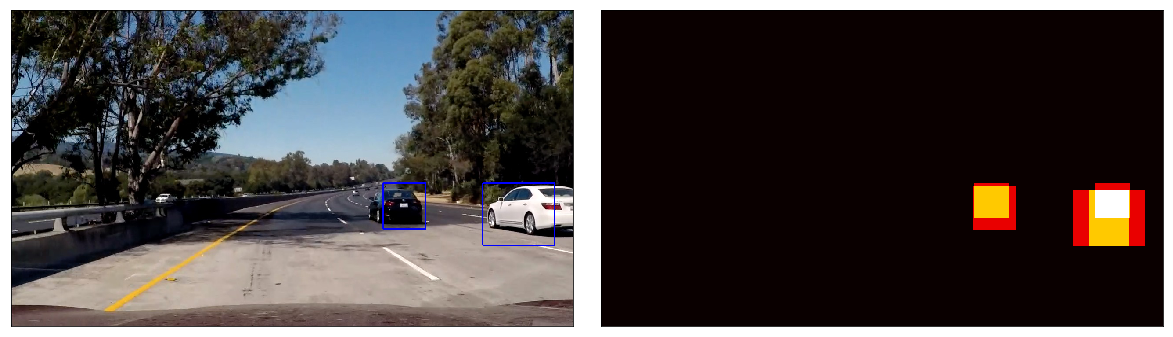

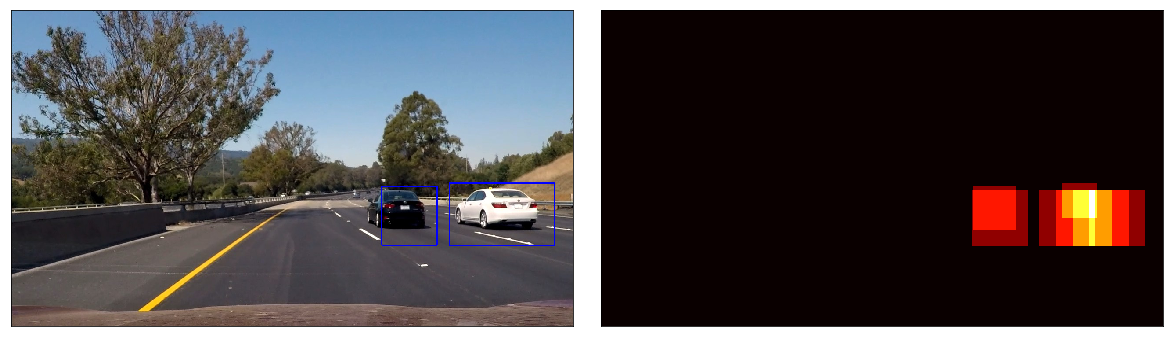

In [9]:
for image_path in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(image_path)
    detection = Pipeline(X_scaler, svc, image)
    detection.run(image)
    
    f = plt.figure(figsize=(16, 8))
    f.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    
    a = f.add_subplot(1, 2, 1, xticks=[], yticks=[])
    a.imshow(image)
    
    a = f.add_subplot(1, 2, 2, xticks=[], yticks=[])
    a.imshow(detection.heatmap, cmap='hot')
    
    plt.show


## Apply the vehicle detection to the video

In [10]:
from moviepy.editor import VideoFileClip

def detect_vehicles_in_video(video_path_prefix):
    output_video_name = 'videos/{}_detected.mp4'.format(video_path_prefix)
    input_video = VideoFileClip("videos/{}.mp4".format(video_path_prefix))

    detection_pipline = Pipeline(X_scaler, svc, input_video.get_frame(0))

    output_video = input_video.fl_image(detection_pipline.run)

    %time output_video.write_videofile(output_video_name, audio=False)

In [11]:
def gif_from_video(video_path_prefix, s=(0,0), f=(0,15)):
    video_file = 'videos/{}_detected.mp4'.format(video_path_prefix)
    
    clip = (VideoFileClip(video_file).subclip(s,f).resize(0.5))
    %time clip.write_gif('videos/{}_detected.gif'.format(video_path_prefix), fps=10)


Running the pipeline on the test video

In [12]:
detect_vehicles_in_video('test_video')

[MoviePy] >>>> Building video videos/test_video_detected.mp4
[MoviePy] Writing video videos/test_video_detected.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:59<00:01,  1.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/test_video_detected.mp4 

Wall time: 1min


In [13]:
gif_from_video('test_video',s=(0, 1.50), f=(0,46))


[MoviePy] Building file videos/test_video_detected.gif with imageio


100%|███████████████████████████████████████▉| 445/446 [00:38<00:00, 11.48it/s]


Wall time: 38.8 s


RUnning the pipeline on the main project video

In [14]:
detect_vehicles_in_video('project_video')

[MoviePy] >>>> Building video videos/project_video_detected.mp4
[MoviePy] Writing video videos/project_video_detected.mp4


100%|█████████████████████████████████████▉| 1260/1261 [32:00<00:01,  1.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_detected.mp4 

Wall time: 32min 1s


In [15]:
gif_from_video('project_video',s=(0, 26), f=(0,46))


[MoviePy] Building file videos/project_video_detected.gif with imageio


100%|███████████████████████████████████████▊| 200/201 [00:16<00:00, 11.77it/s]


Wall time: 17 s
